# Testing by solving Maxwell's equations in InSb

In [1]:
from BeyoundEffMass import *

Initial condition

In [2]:
Δx = 1.25e-6
Δt = 2.08e-15

E0 = 10 # ******
f0 = 1e12
τd = 0.5e-12

def Ez_init(x):
    t = x / c
    return E0 * np.exp(-(t / τd) ** 2) * np.sin(2 * np.pi * f0 * t)
    #return E0 * np.sin(np.pi * t / t[-2]) ** 2 * np.sin(2 * np.pi * f0 * t)

In [3]:
x, Δx = np.linspace(-25 * c * τd, 3 * c * τd, 2000, retstep=True)

In [4]:
Δx

2.0995970045022506e-06

In [5]:
Δt = 0.01 * Δx / c

# Sample length
d = 0.5e-3
Δx2 = 1.25e-6
N2 = int(round(d / Δx2))

In [6]:
sys = CBeyondEffMass(
    Δt = Δt, 
    Δx1 = Δx, 
    
    Δx2 = Δx2,
    N2 = N2,
    
    Ez_init = Ez_init(x), 
    diff_E = lambda _: 0,
    epsilon_infty = 15.6,
    γ = 0.5e12,
    n = 7.3e13,
)

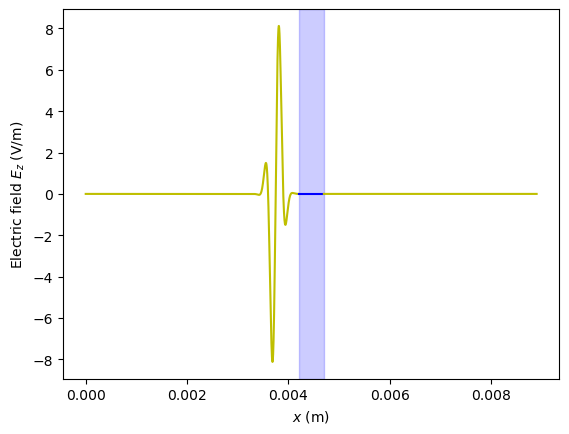

In [7]:
sys.plot_Ez()

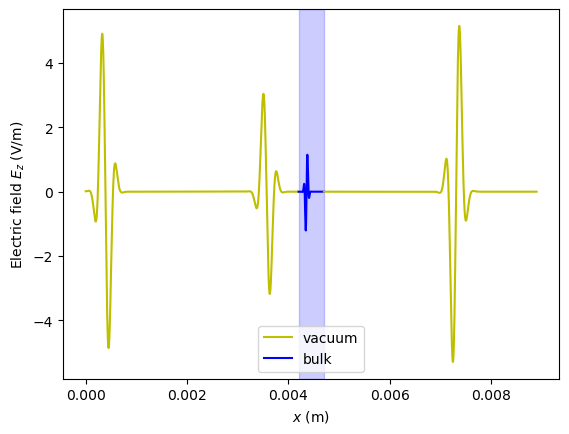

In [19]:
# propagation
n_steps = 20000
t = n_steps * Δt

for _ in range(n_steps):
    sys.single_step_propagation()

sys.plot_Ez()

#full_x = np.hstack([sys.x1, sys.x2, sys.x3])

#plt.plot(full_x, Ez_init(full_x + x_offset - c * t), '--r', label="exact")

plt.legend()
plt.show()